[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fat-forensics/resources/master?filepath=surrogates_overview%2Fsurrogates_overview.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fat-forensics/resources/blob/master/surrogates_overview/surrogates_overview.ipynb)
[![new BSD](https://img.shields.io/github/license/fat-forensics/resources.svg)](https://github.com/fat-forensics/resources/blob/master/LICENCE)

# Interactive Overview of Tabular and Image Surrogates #

This directory contains a Jupyter Notebook that was presented during
the following events:

* [2021 BIAS Summer School][2021_bias-summer-school]; and
* [2021 TAILOR Summer School][2021_tailor-summer-school].

To run the notebook (`surrogates_overview.ipynb`) you need to install a
collection of Python dependencies listed in the `requirements.txt` file
(included in this directory) by executing `pip install -r requirements.txt`.
Alternatively, you can run it via Binder or Colab by clicking the buttons
listed above.

---

This Jupyter Notebook can also be rendered as a [reveal.js][reveal] slide show
through [RISE][rise].
To this end, it needs to be run from within a Jupyter Notebook environment
(not Jupyter Lab).
Next:

1. execute all cells; and
2. launch RISE presentation by clicking the bar chart icon
   (<img src="img/barchart.svg" width=20px />) shown in the
   Jupyter Notebook toolbar.

[2021_tailor-summer-school]: https://events.fat-forensics.org/2021_tailor-summer-school/
[2021_bias-summer-school]: https://events.fat-forensics.org/2021_bias/
[reveal]: https://revealjs.com/
[rise]: https://rise.readthedocs.io/

In [1]:
#@title Install FAT Forensics
# NBVAL_IGNORE_OUTPUT
import os
REPOSITORY = ('https://raw.githubusercontent.com/fat-forensics/resources/'
              'master/surrogates_overview/{}')
SCRIPTS = ['__init__.py', 'image_classifier.py', 'imagenet_label_map.py',
           'surrogates_overview.py']

if 'google.colab' in str(get_ipython()):
    require = 'requirements.txt'
    require_url = REPOSITORY.format(require)
    if not os.path.exists(require):
        ! wget $require_url -O $require
        ! pip install -r $require

    ! mkdir -p img
    img = 'img/{}'.format('doggo.jpg')
    img_url = REPOSITORY.format(img)
    if not os.path.exists(img):
        ! wget $img_url -O $img

    ! mkdir -p scripts
    for script in SCRIPTS:
        script = 'scripts/{}'.format(script)
        url = REPOSITORY.format(script)
        if not os.path.exists(script):
            ! wget $url -O $script

In [2]:
#@title Set up matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [3]:
#@title Set up other dependencies
from PIL import Image

import scripts.surrogates_overview as exo
import scripts.image_classifier as imgclf
import numpy as np

import sklearn.datasets
import sklearn.linear_model

22-Sep-22 11:15:37 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [4]:
#@title Set up image classification
# Load the image
doggo_img = Image.open('img/doggo.jpg')
doggo_array = np.array(doggo_img)

# Load the classifier
clf = imgclf.ImageClassifier()

# doggo_y = clf.predict(doggo)
doggo_proba = clf.predict_proba([doggo_array])
doggo_labels_3 = clf.proba2tuple(doggo_proba, labels_no=3)[0]

# Fix global options
SAMPLES = 10
BATCH = 50

<h2 style="text-align: center">Surrogate Explainers of Image Data</h2>

### Black-box Prediction ###

In [5]:
doggo_labels_3

[('tennis ball', 0.9955829, 852),
 ('golden retriever', 0.004185235, 207),
 ('Labrador retriever', 0.00022407941, 208)]

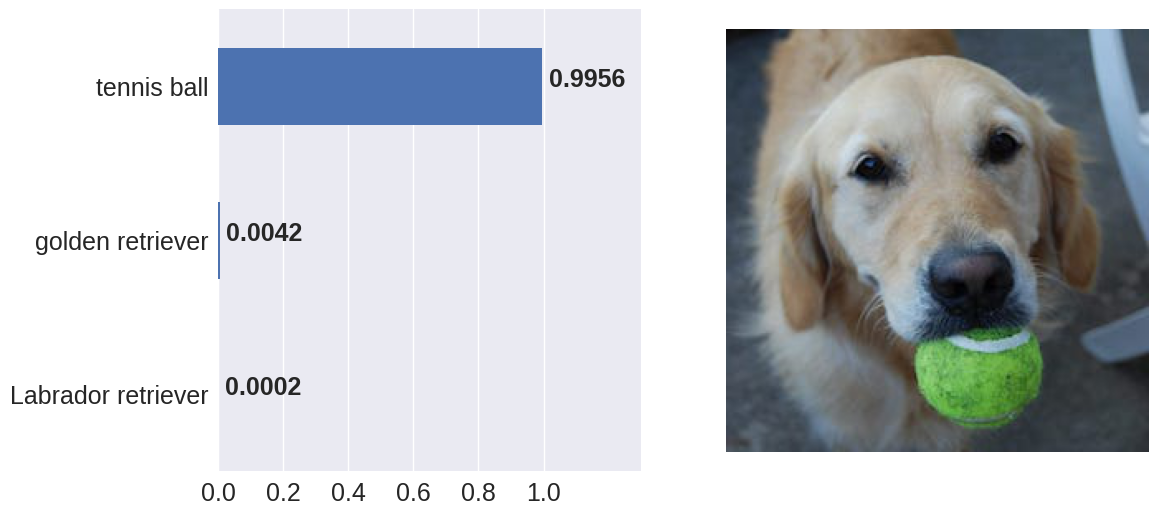

In [6]:
# NBVAL_IGNORE_OUTPUT
classification = exo.plot_image_prediction(doggo_labels_3, doggo_array)

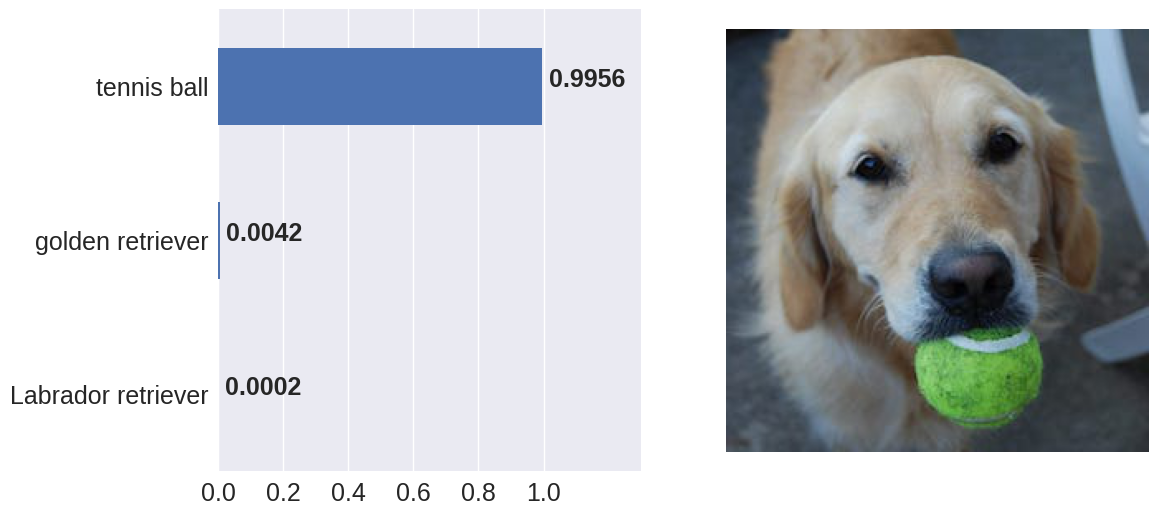

In [7]:
# NBVAL_IGNORE_OUTPUT
classification

In [8]:
# LIME explanation for tennis ball/golden retriever/Labrador retriever <->
# image colouring <-> bar plot
explain_classes = [(i[0], i[2]) for i in doggo_labels_3]
blimey_image = exo.build_image_blimey(
    doggo_array,
    clf.predict_proba,
    explain_classes,
    explanation_size=5,
    segments_number=13,
    occlusion_colour='mean',
    samples_number=SAMPLES,
    batch_size=BATCH,
    random_seed=42)

22-Sep-22 11:15:41 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-22 11:15:41 fatf         INFO     Seeding RNGs with 42.


In [9]:
blimey_image['surrogates']

{852: {'name': 'tennis ball',
  'model': Ridge(alpha=1, random_state=42),
  'explanation': [(13, 0.34635231347898937),
   (11, 0.2678055638194571),
   (4, -0.10639800482059991),
   (6, 0.08345836646747357),
   (9, 0.07366959135631329)]},
 207: {'name': 'golden retriever',
  'model': Ridge(alpha=1, random_state=42),
  'explanation': [(13, -0.24406814793545573),
   (11, -0.20456168209018133),
   (9, -0.18667836516812542),
   (4, 0.1500117817210037),
   (3, 0.11589487436956866)]},
 208: {'name': 'Labrador retriever',
  'model': Ridge(alpha=1, random_state=42),
  'explanation': [(13, -0.08396002518577293),
   (0, -0.06449833797789309),
   (9, 0.058455875336641885),
   (1, 0.04369760592194087),
   (11, -0.03595849889697442)]}}

### Prediction Explanation ###

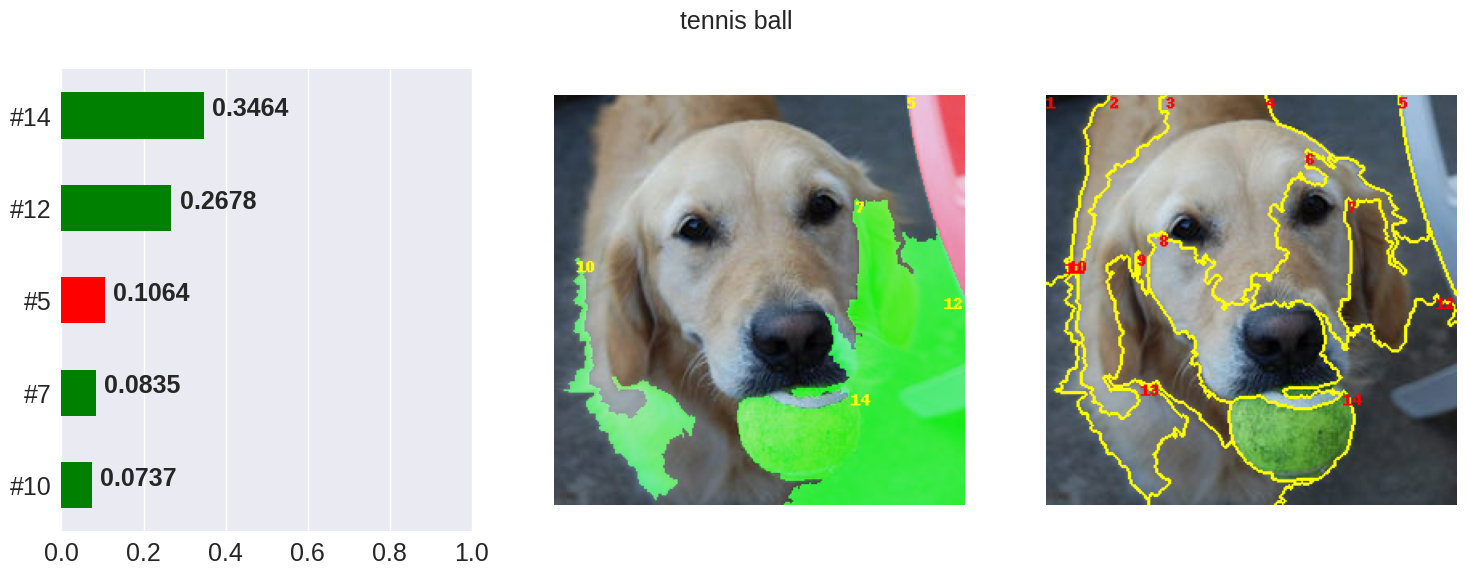

In [10]:
# NBVAL_IGNORE_OUTPUT
exo.plot_image_explanation(blimey_image, explain_classes[0])

### Prediction Explanation ###

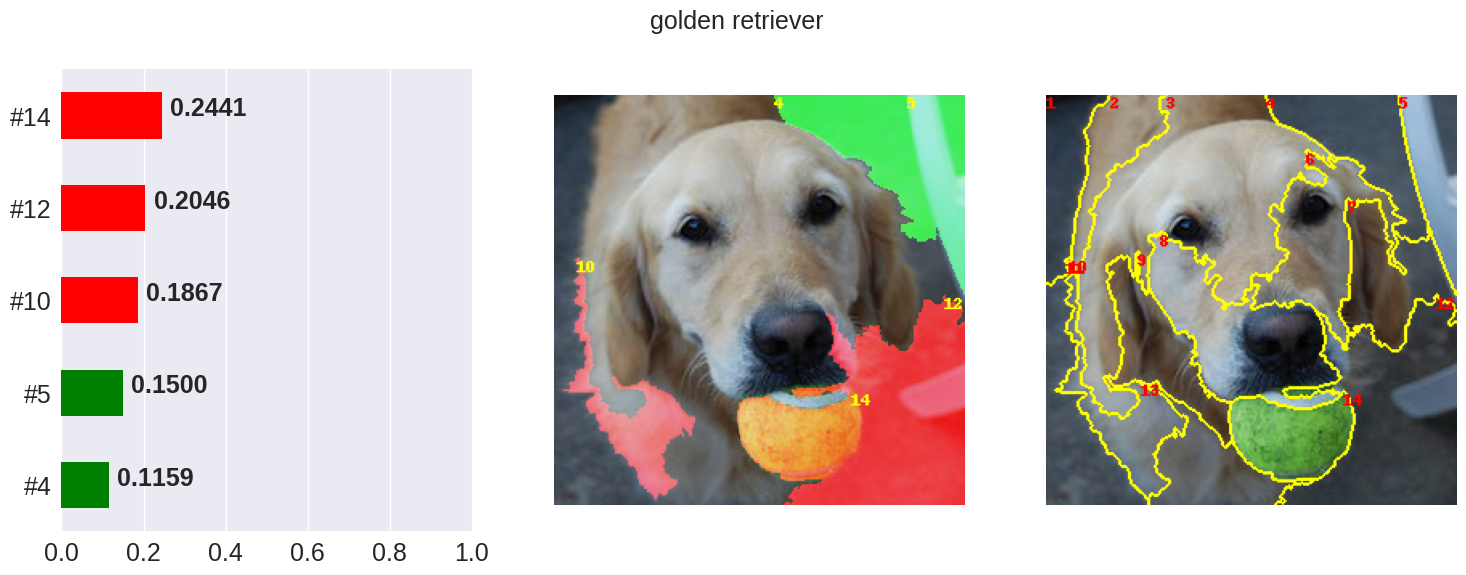

In [11]:
# NBVAL_IGNORE_OUTPUT
exo.plot_image_explanation(blimey_image, explain_classes[1])

### Prediction Explanation ###

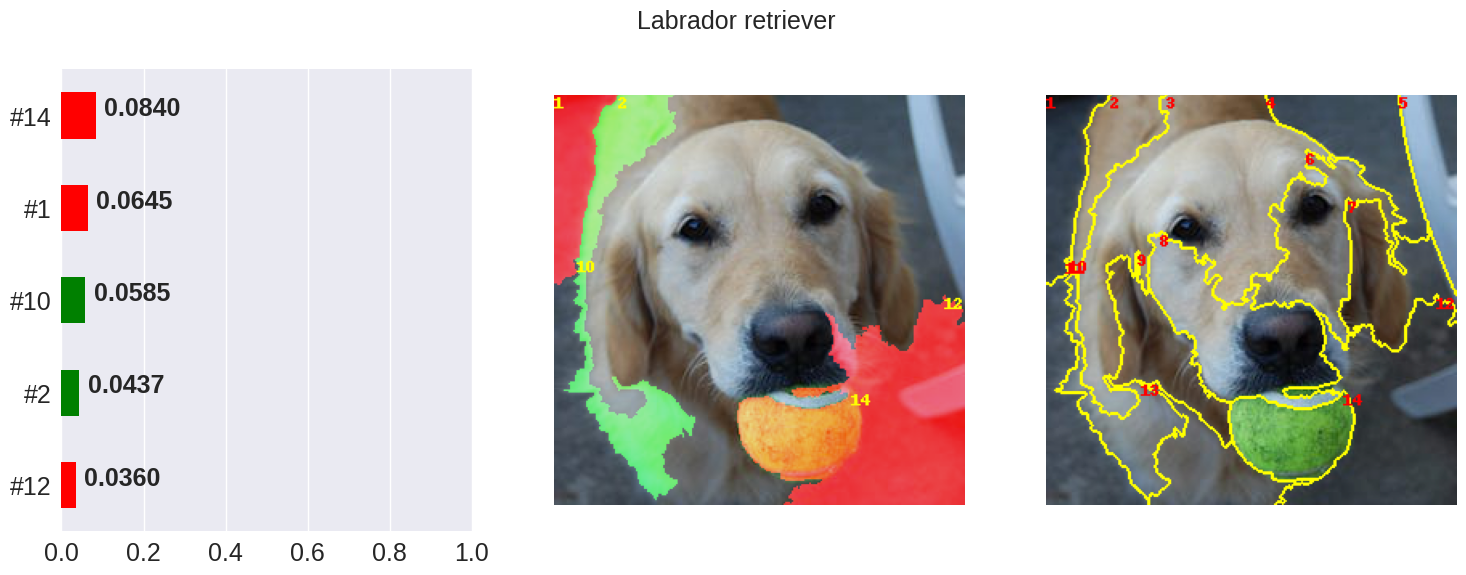

In [12]:
# NBVAL_IGNORE_OUTPUT
exo.plot_image_explanation(blimey_image, explain_classes[2])

### Explainer Demo ###

In [13]:
# Configure widgets to select occlusion colour, segmentation granularity and
# explained class
colour_selection = {
    i: i for i in ['mean', 'black', 'white', 'randomise-patch', 'green']
}
granularity_selection = {'low': 13, 'medium': 30, 'high': 50}
class_selection = {label: class_id for label, class_id in explain_classes}

In [14]:
# Generate explanations
blimey_image_collection = {}
for gran_name, gran_number in granularity_selection.items():
    blimey_image_collection[gran_name] = {}
    for col_name in colour_selection:
        blimey_image_collection[gran_name][col_name] = exo.build_image_blimey(
            doggo_array,
            clf.predict_proba,
            explain_classes,
            explanation_size=5,
            segments_number=gran_number,
            occlusion_colour=col_name,
            samples_number=SAMPLES,
            batch_size=BATCH,
            random_seed=42)

22-Sep-22 11:15:44 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-22 11:15:44 fatf         INFO     Seeding RNGs with 42.
22-Sep-22 11:15:44 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-22 11:15:44 fatf         INFO     Seeding RNGs with 42.
22-Sep-22 11:15:45 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-22 11:15:45 fatf         INFO     Seeding RNGs with 42.
22-Sep-22 11:15:46 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-22 11:15:46 fatf         INFO     Seeding RNGs with 42.
22-Sep-22 11:15:46 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-22 11:15:46 fatf         INFO     Seeding RNGs with 42.
22-Sep-22 11:15:47 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-22 11:15:47 fatf         INFO     Seeding RNGs with 42.
22-Sep-22 11:15:47 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-22 11:15:47 fatf         INFO     Seeding RNGs w

In [15]:
# NBVAL_IGNORE_OUTPUT
# Plot bar-plot explanation, image explanation and randomly occluded example
surrogate_image_explainer = exo.generate_image_widget(
    blimey_image_collection,
    granularity_selection,
    colour_selection,
    class_selection)

In [16]:
# NBVAL_IGNORE_OUTPUT
surrogate_image_explainer

<h2 style="text-align: center">Surrogate Explainers of Tabular Data</h2>

### Classifying Iris Flowers ###

<img width="30%" align="middle" src="img/iris.png" alt="Iris Data Set" style="display: block; margin-left: auto; margin-right: auto;">
<img width="70%" align="middle" src="img/iris-classes.jpeg" alt="Iris Classes" style="display: block; margin-left: auto; margin-right: auto;">

In [17]:
#@title Get iris data set and fit "black box"
# Load the iris data set
iris = sklearn.datasets.load_iris()
iris_X = iris.data  # [:, :2]  #  take the first two features only
iris_y = iris.target

iris_labels = iris.target_names
iris_feature_names = iris.feature_names

label2class = {lab: i for i, lab in enumerate(iris_labels)}
feature2name = {i: feat for i, feat in enumerate(iris_feature_names)}

# Fit the classifier
logreg = sklearn.linear_model.LogisticRegression(C=1e5)
logreg.fit(iris_X, iris_y)

# Fix global options
SAMPLE_IRIS = False
IRIS_SAMPLES = 50000

In [18]:
# Configure widgets to select explained instance, discretisation and
# explained class
_dtype = iris_X.dtype
explained_instances = {
    'setosa': np.array([5, 3.5, 1.5, 0.25]).astype(_dtype),
    'versicolor': np.array([5.5, 2.75, 4.5, 1.25]).astype(_dtype),
    'virginica': np.array([7, 3, 5.5, 2.25]).astype(_dtype)
}

petal_length_idx = iris_feature_names.index('petal length (cm)')
petal_length_bins = [1, 2, 3, 4, 5, 6, 7]
petal_width_idx = iris_feature_names.index('petal width (cm)')
petal_width_bins = [0, .5, 1, 1.5, 2, 2.5]
discretisation = {
    petal_length_idx: {
        'range': petal_length_bins,
        'default': [2, 3],
        'step': 1
    },
    petal_width_idx: {
        'range': petal_width_bins,
        'default': [.5, 1],
        'step': .5
    }
}

In [19]:
# NBVAL_IGNORE_OUTPUT
surrogate_tabular_explainer = exo.generate_tabular_widget(
    explained_instances,
    discretisation,
    label2class,
    feature2name,
    iris_X,
    iris_y,
    logreg.predict_proba,
    samples_number=IRIS_SAMPLES,
    sample=SAMPLE_IRIS,
    random_seed=42)

### Explainer Demo ###

In [20]:
# NBVAL_IGNORE_OUTPUT
surrogate_tabular_explainer